In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
plt.style.use('ggplot')

In [2]:
import pickle
with open('orfs.pickle','rb') as f:
    orfs = pickle.load(f)

orfs.head()

,start,end,length,frame,isCDS,scores
0,1,36,36,1,False,1.181405
1,40,51,12,1,False,2.758633
2,55,72,18,1,False,-2.459251
3,76,81,6,1,False,0.568646
4,85,87,3,1,False,NaN


## 2 ROC
1. Generate a single plot showing ROC curves with respect to 
    1. length threshold, say in red, and 
    2. Markov model score, say in green, 
using the full 0-1 range for both axes. 

2. Additionally, (c) generate such a plot "zoomed-in" to the upper-left corner to show the crossover between the two curves. 

For maximum clarity, you probably do not want the two axes to be equally scaled in the "zoomed" view. (Step (c) is important since there are many, many more short ORFs (mostly non-genes) than long ones (mostly real genes), which drives the ROC curves into the upper-left corner.) 

3. Also calculate and show Area Under the Curve (AUC) for each curve.

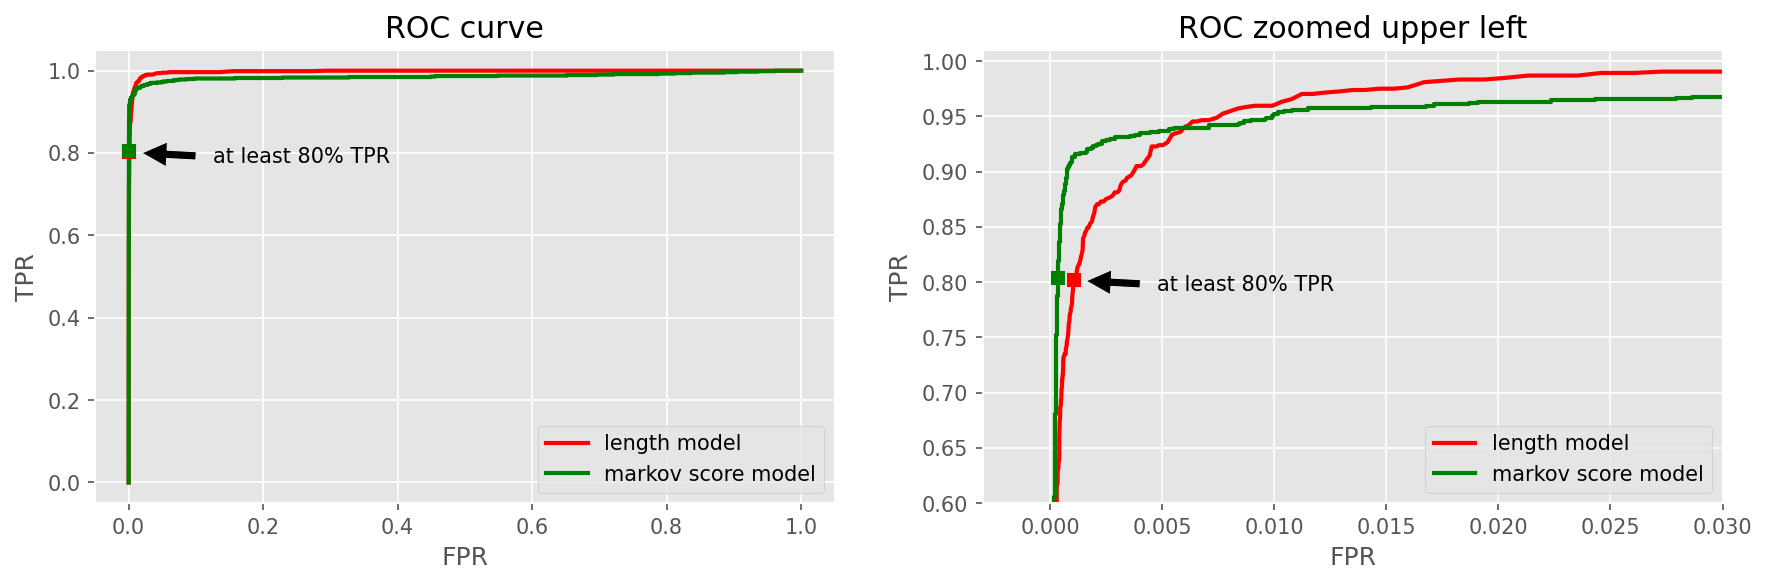

Length threshold AUC = 0.998 
Markov score AUC = 0.986


In [3]:
import sklearn.metrics
fig, axes = plt.subplots(1,2)
fig.set_figwidth(14)
score_orf = orfs.dropna()

fpr_l, tpr_l, thresholds_l = sklearn.metrics.roc_curve(score_orf.isCDS, score_orf.length)
auc_l = sklearn.metrics.auc(fpr_l, tpr_l)
fpr_s, tpr_s, thresholds_s = sklearn.metrics.roc_curve(score_orf.isCDS, score_orf.scores)
auc_s = sklearn.metrics.auc(fpr_s, tpr_s)

fig.set_dpi(150)


for ax in axes:
    ax.plot(fpr_l, tpr_l, color = 'red',lw = 2)
    ax.plot(fpr_s, tpr_s, color = 'green',lw = 2)    
    ax.legend([f'length model', f'markov score model'])
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    
    ax.plot(fpr_l[243], tpr_l[243], "s", color = "red")
    ax.plot(fpr_s[68], tpr_s[68], "s", color = "green")
    

    
    ax.annotate('at least 80% TPR',
       xy=(fpr_l[243], tpr_l[243]),
       xytext=(40, -5),    # fraction, fraction
       textcoords='offset points',
       arrowprops=dict(facecolor='black', shrink=0.15),
       clip_on=True )

    
axes[0].set_title('ROC curve')


axes[1].set_xbound(-0.003,0.03)
axes[1].set_ybound(0.6,1.01)
axes[1].set_title('ROC zoomed upper left')
plt.show()

print(f'Length threshold AUC = {auc_l:.3f} \nMarkov score AUC = {auc_s:.3f}')

## 3 
If your only option was to predict based on an ORF length threshold, what is the ~minimum~ maximum threshold that would achieve a true positive rate of at least 80%, how many true positives and how many false positives would you see using that threshold? Optionally, plot this point on the ROC curve above.


    condition positive (P)
        the number of real positive cases in the data
    condition negative (N)
        the number of real negative cases in the data
TPR = TP/P = TP/(TP+FN)

FPR = FP/N = FP/(FP+N)

In [4]:
thresholddf = pd.DataFrame({'tpr':tpr_l,'threshold':thresholds_l})
# print(score_orf[score_orf.isCDS].length.min())
# thresholddf.tail(20)

thresholddf[thresholddf['tpr'] >= 0.8].head()

,tpr,threshold
243,0.801663,432
244,0.801663,429
245,0.804038,426
246,0.807601,423
247,0.809976,420


In [5]:
pred = score_orf[score_orf.length>=432]

p = score_orf.isCDS.sum()
n = (~score_orf.isCDS).sum()
# print(len(pred))
pred.isCDS.sum() , (~pred.isCDS).sum()

(675, 102)

Maximum length threshold for at least 80% TPR = 432

using that threshold true positives =  675 and  false positives  = 102


## 4
If your only option was to predict based on a log Markov model score threshold, what is the minimum maximum threshold that would achieve a true positive rate of at least 80%, how many true positives and how many false positives would you see using that threshold? Optionally, plot this point on the ROC curve above.

In [6]:
scoredf = pd.DataFrame({'tpr':tpr_s,'threshold':thresholds_s})
scoredf[scoredf['tpr'] >= 0.8].head()

,tpr,threshold
68,0.804038,35.651812
69,0.804038,35.647811
70,0.809976,35.312610
71,0.809976,35.284226
72,0.819477,34.644724


In [7]:
pred = score_orf[score_orf.scores>=35.651812]
pred.isCDS.sum() , (~pred.isCDS).sum()

(676, 34)

Maximum length threshold for at least 80% TPR = 35.6518

using that threshold true positives =  676 and  false positives  = 34

## 5
Generate a scatter-plot of Markov model score (Y-axis) vs ORF length (X-axis) for each long and each short ORF.

Color points according to their status wrt "simple plus strand CDSs" from GenBank (true protein ORFs: orange; non-proteins: blue)

Summarize the short ORFs by the single point that falls at the median x, median y of the ORFs of length < 50. Call this point A. Likewise, summarize the long ORFs by the single point that falls at the median x, median y of the ORFs of length > 1400; call this B. Overlay your plot with some visually distinct symbol at A and B, and connect them by a straight line segment. 


 Also draw a straight line perpendicular to this line segment and crossing it at x = Ax + 0.20 * (Bx - Ax), i.e., 20% of the way from A to B. Calculate the equation of this line.

In [11]:
# def get_distance(length, score):
#     return 
def get_intercept_diff(row):
    '''
    y-mx-c = <val>
    '''
    return row.scores - orth_slope*row.length - orth_intercept

In [21]:
import numpy as np
short = score_orf[score_orf.length<50]
long = score_orf[score_orf.length>1400]
short_median_x, short_median_y = np.median(short.length), np.median(short.scores)
long_median_x, long_median_y = np.median(long.length), np.median(long.scores)


slope = (long_median_y- short_median_y)/(long_median_x-short_median_x)
intercept = long_median_y-slope*long_median_x

x = short_median_x + 0.20 * (long_median_x - short_median_x)
y = slope*x + intercept

orth_slope = -1/slope
orth_intercept = y-orth_slope*x #y-mx



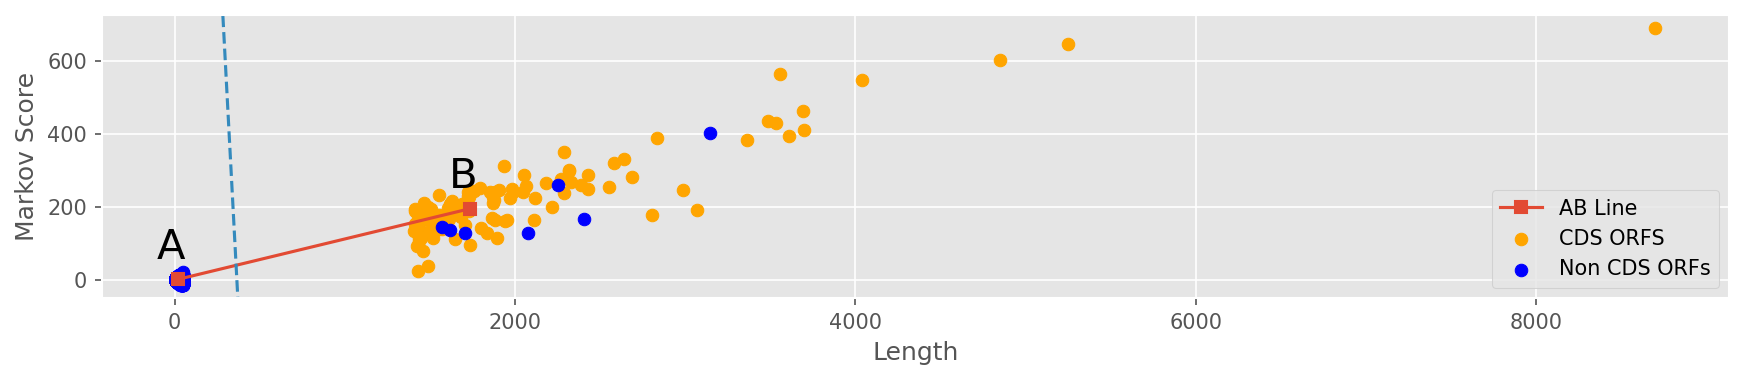

In [72]:
fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(2.5)
fig.set_dpi(150)
for df in [short, long]:
    ax.scatter(df[df.isCDS].length, df[df.isCDS].scores, color='orange')
    ax.scatter(df[~df.isCDS].length, df[~df.isCDS].scores, color='blue')
# ax.plot(short_median_x, short_median_y, "s", color = "cyan")
# ax.plot(long_median_x, long_median_y, "s", color = "red")
ax.plot([short_median_x, long_median_x], [short_median_y, long_median_y],marker ='s')
ax.annotate('A',
   xy=(short_median_x, short_median_y),
   xytext=(-10, 10 ),    # fraction, fraction
   textcoords='offset points',
    fontsize=20,
   clip_on=True )
ax.annotate('B',
   xy=(long_median_x, long_median_y),
   xytext=(-10, 10 ),     # fraction, fraction
   textcoords='offset points',
            fontsize=20,
   clip_on=True )
xlim = ax.get_xlim()
ylim = ax.get_ylim() 
x_vals = np.array(ax.get_xlim())
y_vals = orth_intercept + orth_slope * x_vals
ax.set_xlabel('Length')
ax.set_ylabel('Markov Score')
ax.legend(['AB Line', 'CDS ORFS', 'Non CDS ORFs'])

ax.plot(x_vals, y_vals, '--')



ax.set_xbound(*xlim)
ax.set_ybound(*ylim)

How well does this work? Find its associated True Positive and False Positive counts and rates (on the set of all ORFs, not just the short/long training set).

Calculate distance of each point from line and plot ROC based on that

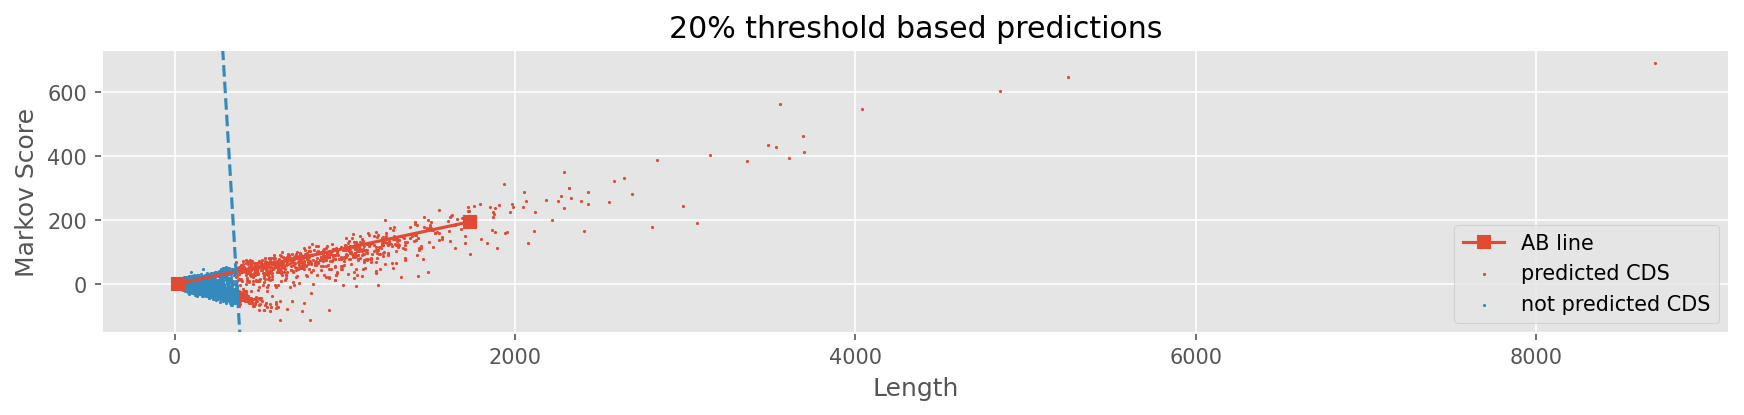

In [80]:
fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(2.5)
fig.set_dpi(150)
i_diffs = score_orf.apply(get_intercept_diff, axis = 1)

ax.plot([short_median_x, long_median_x], [short_median_y, long_median_y],marker ='s')

ax.scatter(score_orf[i_diffs>0].length, score_orf[i_diffs>0].scores, s = 1)
ax.scatter(score_orf[i_diffs<0].length, score_orf[i_diffs<0].scores,s = 1)

xlim = ax.get_xlim()
ylim = ax.get_ylim() 

ax.set_title('20% threshold based predictions')
ax.set_xlabel('Length')
ax.set_ylabel('Markov Score')
ax.legend(['AB line','predicted CDS', 'not predicted CDS'],loc = 'lower right')
ax.plot(x_vals, y_vals, '--')


ax.set_xbound(*xlim)
ax.set_ybound(*ylim)

In [33]:
pred = score_orf[i_diffs>0]
pred.isCDS.sum() , (~pred.isCDS).sum()

(723, 168)

Using points above/to ther right the threshold line as +ve and below/to the left as negative,

true positives = 723 and false positives = 168

### ROC Curve by sliding the threshold line

I used the formula `y-mx-c` output as the flashbulb model score, then ROC curve is plotted using the scores as thresholds. For points x,y These scores are actully intercept diffenrence between a line with slope m passing through x, y vs the intercept of line passing through 20% threshold point.

Since slope is constant while calculating the intercept difference , This will be equivalent to sliding the flashbulb line explained in the assignment question. 

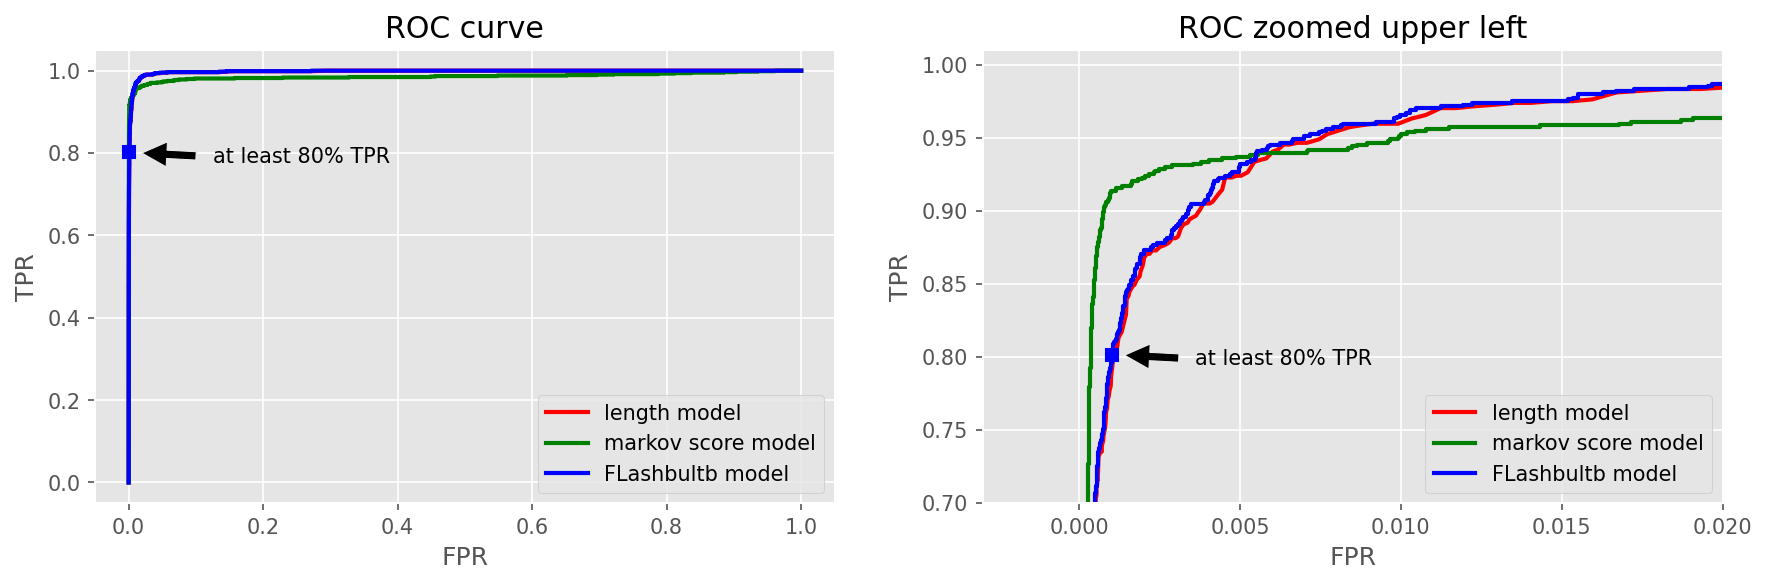

Flashbulb model AUC =  0.9979613728388557


In [89]:
fpr_c, tpr_c, thresholds_c = sklearn.metrics.roc_curve(score_orf.isCDS, i_diffs)
auc_c = sklearn.metrics.auc(fpr_c, tpr_c)

fig, axes = plt.subplots(1,2)
fig.set_figwidth(14)
fig.set_dpi(150)
for ax in axes:
    ax.plot(fpr_l, tpr_l, color = 'red',lw = 2)
    ax.plot(fpr_s, tpr_s, color = 'green',lw = 2)
    ax.plot(fpr_c, tpr_c, color = 'blue',lw = 2)    
    ax.legend([f'length model', f'markov score model', 'FLashbultb model'])
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    
    ax.plot(fpr_c[152], tpr_c[152], "s", color = "blue")
    

    
    ax.annotate('at least 80% TPR',
       xy=(fpr_c[152], tpr_c[152]),
       xytext=(40, -5),    # fraction, fraction
       textcoords='offset points',
       arrowprops=dict(facecolor='black', shrink=0.15),
       clip_on=True )


    
axes[0].set_title('ROC curve')


axes[1].set_xbound(-0.003,0.02)
axes[1].set_ybound(0.7,1.01)
axes[1].set_title('ROC zoomed upper left')
plt.show()


print('Flashbulb model AUC = ', auc_c)

In [86]:
scoredf = pd.DataFrame({'tpr':tpr_c,'threshold':thresholds_c})
scoredf[scoredf['tpr'] >= 0.8].head()


,tpr,threshold
152,0.801663,623.414600
153,0.801663,621.042752
154,0.802850,605.035895
155,0.802850,584.544198
156,0.806413,554.656240


In [93]:
pred = score_orf[i_diffs > 623.414600]
pred.isCDS.sum() , (~pred.isCDS).sum()

(675, 99)

For 80% TPR, true positives = 675 and false positives = 99

## How to improve the results?

The actual true CDS vs false CSD distribution is shown in the following graph. The flashbulb line which sets the threshold clearly is not the best classifier. More precisely, the slope does not seem to be accurate. So here are few suggestions for improvement.
1. Use a different slope. Perceptrons or gradient descent or even simple grid search on slope can be used to come up with the best slope. 
2. Use a non linear boundry. Again, neural networks can be used to create a better boundry.
3. Use annotated genes to build the markov model instead of relying on long ORFS. That way the markov scores will be more accurate.
4. Increase training data. 
5. Try with higher/lower order markov models. Tuning k can help the results. As a thumb rule, try higher k if more data available else experiment with lower k.
6. Tune pseudo count. Find number of kmers having zero probability without pseudo count. If the number is high, reduce pseudo count or reduce k.
7. Remove stop codons from -ve training data. 

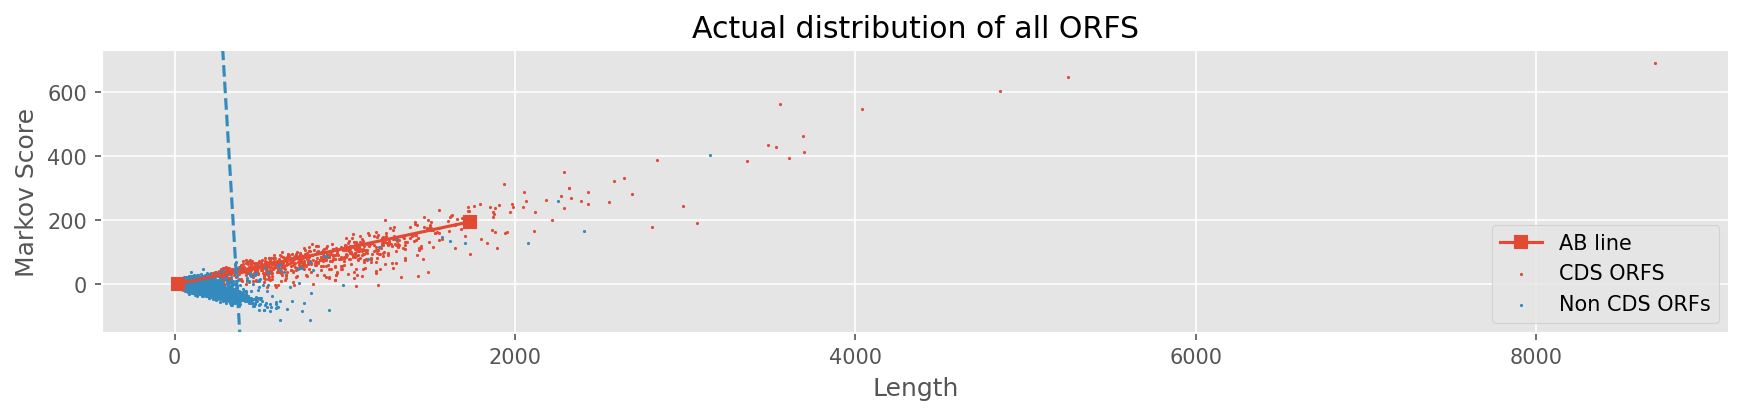

In [95]:
fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(2.5)
fig.set_dpi(150)
i_diffs = score_orf.apply(get_intercept_diff, axis = 1)

ax.plot([short_median_x, long_median_x], [short_median_y, long_median_y],marker ='s')

ax.scatter(score_orf[score_orf.isCDS].length, score_orf[score_orf.isCDS].scores, s = 1)
ax.scatter(score_orf[~score_orf.isCDS].length, score_orf[~score_orf.isCDS].scores,s = 1)
ax.set_xlabel('Length')
ax.set_ylabel('Markov Score')
ax.set_title('Actual distribution of all ORFS')
ax.legend(['AB line','CDS ORFS', 'Non CDS ORFs'],loc = 'lower right')
ax.plot(x_vals, y_vals, '--')


ax.set_xbound(*xlim)
ax.set_ybound(*ylim)
plt.show()